# 2.3 Dimensionnement d'une poutre

## 1) Methode Gloutonne

Dans ce problème, il sera question d'optimisation multi-objectif puisque l'on cherche à minimiser à la fois le poids et la deflexion de la poutre sous certaines contraintes.

Les fonctions qui donnent le poids et la deflexion de la poutre, étant faciles à évaluer, nous pouvons utiliser la méthode gloutonne (gourmande) dans laquelle il sera question de générer 100000 points qui réalisent les contraintes physiques imposées et de tracer un front de Pareto.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time 
import pandas as pd
from scipy.optimize import minimize

# On définit nos fonctions poids et deflexion

def poids(a,b):
    return a**2-b**2

def deflexion(a,b):
    return 0.001/(0.01+a**4-b**4)

N=100000 #Nombre de points que nous allons générer

# On definit nos 2 vecteurs aléatoires et nos 2 vecteurs de poids et de deflexion
a = 0.02+0.98*np.random.rand(1,N)[0]
b = (np.random.rand(1,N)*(a-0.01))[0]

p = []
d = []

for i in range(N):
    p.append(poids(a[i],b[i]))
    d.append(deflexion(a[i],b[i]))

p=np.array(p)
d=np.array(d)


La recherche des points Pareto Optimales se fait en 2 étapes:

- Pour chaque point généré, on stocke sous forme de liste l'ensemble des points situés en bas et à gauche de lui (ayant un poids et une deflexion inférieurs à lui)

- Si cette liste est vide, alors ce point est pareto-optimal. Dans le cas contraire, ce point n'est pas retenu

$\textbf{Version 1 :}$ : Version la plus gourmande que l'on teste avec 1000 points

6.434283018112183


Text(0,0.5,'Deformation de la poutre')

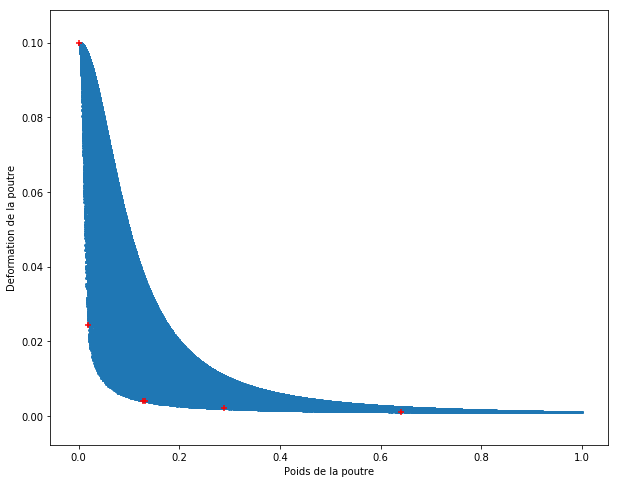

In [2]:
# Trouver l'ensemble de points appartenant à la courbe de Pareto
pareto_opti=[]
debut=time.time()
for i in range(1000):
    pi = p[i]
    di = d[i]
    
    index1 = np.where(p < p[i])[0]
    index2 = np.where(list(d[index1]) < d[i])[0]
    
    if(len(index2)==0):
        pareto_opti.append(i)

print(time.time()-debut)

plt.figure(figsize=(10,8))
plt.scatter(x=p,y=d,linewidths=0.001,marker='.')
plt.scatter(x = list(p[pareto_opti]),y = list(d[pareto_opti]),c='red',marker='+',linewidths=10)
plt.xlabel('Poids de la poutre')
plt.ylabel('Deformation de la poutre')

Si on simule 1000000 points avec cet algorithme initial, la recherche des points Pareto Optimal prend beaucoup de temps et n'est pas optimal. 

On va proposer une amélioration de l'algorithme précédent afin qu'il prenne moins de temps. L'idée ici est d'éliminer à chaque itération l'ensemble des points en haut à droite de ce point (tous ces points sont de facto dominés par le point que l'on étudie) afin de boucler sur moins de points au total.

Avec 100000 points on arrive à un temps d'execution de 53 secondes, temps qui reste assez élevé.


$\textbf{Version 2 :}$ On élimine l'ensemble des points dominés par le point d'étude

50.7776837348938


Text(0,0.5,'Deformation de la poutre')

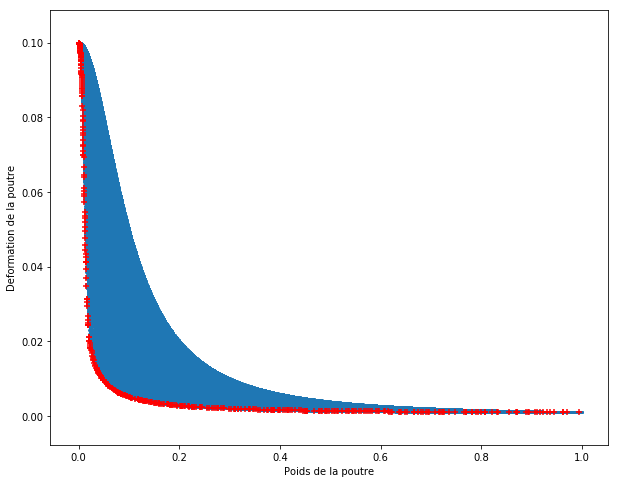

In [3]:
# Trouver l'ensemble de points appartenant à la courbe de Pareto
pareto_opti=[]
debut=time.time()
index=[i for i in range(N)]
for i in range(N):   
    if i in index:
        pi = p[i]
        di = d[i]
        remove_value=np.where((p > p[i]) & (d > d[i]))[0]
        index=[j for j in index if j not in remove_value]
        index1 = np.where(p < p[i])[0]
        index2 = np.where(list(d[index1]) < d[i])[0]
    
        if(len(index2)==0):
            pareto_opti.append(i)
print(time.time()-debut)            

# Tracer le graphique

plt.figure(figsize=(10,8))
plt.scatter(x=p,y=d,linewidths=0.001,marker='.')
plt.scatter(x = list(p[pareto_opti]),y = list(d[pareto_opti]),c='red',marker='+',linewidths=10)
plt.xlabel('Poids de la poutre')
plt.ylabel('Deformation de la poutre')

En repensant à cette dernière amélioration, on se rend compte que la vitesse de l'algorithme est complètement determinée par les points initiaux: plus on élimine de points au début de l'algorithme et plus il sera rapide. Ainsi, en triant initialement nos points par ceux qui ont la plus petite déformation et le plus petit poids, on arrive à accélérer l'algorithme considérablement.

$\textbf{Version 3 :}$ On optimise l'élimination des points précédents

In [4]:
# Trouver l'ensemble de points appartenant à la courbe de Pareto
df=pd.DataFrame(data=p,columns={'Poids'})
df['Deformation']=d
df=df.sort_values(by=['Poids','Deformation']).reset_index(drop=True)

pareto_opti=[]
ini=[i for i in range(N)]
df_index=pd.DataFrame(data=np.array(ini),columns={'ind'})
debut=time.time()
compt=0
for i in df.index:  
    
    if i in df_index.index:
        compt+=1
        pi = df.loc[i,'Poids']
        di = df.loc[i,'Deformation']
        remove_index = df.loc[(df.Poids > p[i]) & (df.Deformation > d[i])].index
        df_index = df_index.drop(labels=remove_index,errors='ignore')
        index1 = df.loc[(df.Poids < pi) & (df.Deformation < di)].index
    
        if(len(index1)==0):
            pareto_opti.append(i)
    
    else:
        pass
            
print('Temps execution: ',time.time()-debut)
print('Nombre entrée: ', compt)

Temps execution:  16.73214840888977
Nombre entrée:  4182


Text(0,0.5,'Deformation de la poutre')

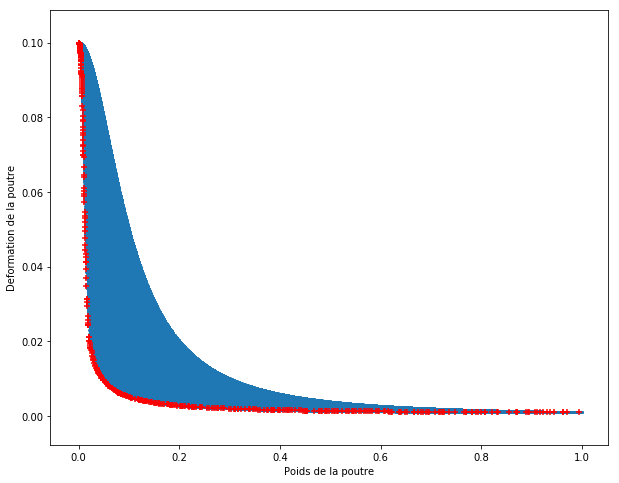

In [5]:
# Plot graphique

plt.figure(figsize=(10,8))
plt.scatter(x=df.Poids,y=df.Deformation,linewidths=0.001,marker='.')
plt.scatter(x = df.loc[pareto_opti,'Poids'],y = df.loc[pareto_opti,'Deformation'],c='red',marker='+',linewidths=10)
plt.xlabel('Poids de la poutre')
plt.ylabel('Deformation de la poutre')

## 2)Méthode plus sophistiquée:

On transforme ici notre problème en problème mono-objectif:

$$ \underset{(a,b)}{\min} : \lambda*p(a,b)+d(a,b) $$

On fait varier $\lambda\$ sur un intervalle afin de donner à chaque itération plus de poids à l'une des 2 fonctions que l'on cherche à minimiser et on résout plusieurs fois le problème de minimisation précédent.

On notera que le problème de minimisation sous contraintes se fera en utilisant une méthode de type quasi Newton (SLSQP) dans laquelle on définira des bornes et des contraintes. Aussi, comme les solutions obtenus dépendent de notre point d'initialisation, on définira à chaque itération un x0 différent que l'on générera de manière random


Temps execution : 2.8283514976501465


Text(0,0.5,'Deformation de la poutre')

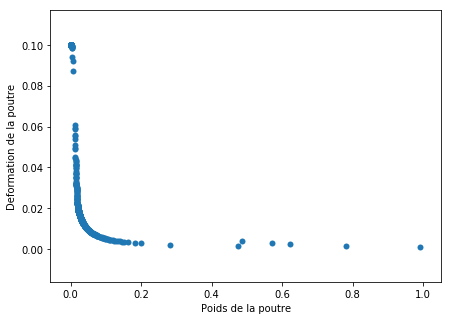

In [6]:
# On définit la nouvelle fonction à minimiser 
def fmono(x,lamb):
    return lamb*poids(x[0],x[1])+deflexion(x[0],x[1])

debut=time.time()
# On génére un vecteur de lambdas et on résout plusieurs fois le problème de minimisation
bnds=tuple([[0.02,1],[0,None]])
lam=np.linspace(0,10,5000)
xmin=[]

constraints=({'type': 'ineq', 'fun': lambda x:  x[0]-x[1]-0.01})
for lamb in lam:
        rand=np.random.rand(1)
        x0=[rand,np.random.uniform(0,rand-0.01)]
        xmin.append(minimize(fun=fmono,x0=x0,args=(lamb),method='SLSQP',constraints=constraints,bounds=bnds,tol=1e-6)['x'])

print('Temps execution :', time.time()-debut)
# On garde que les xmin qui vérifient les contraintes.
df=pd.DataFrame(xmin,columns={'a','b'})
df=df[df.b<=df.a-0.01]
for index in df.index:
    
    df.loc[index,'Poids']=poids(df.loc[index,'a'],df.loc[index,'b'])
    df.loc[index,'Deflexion']=deflexion(df.loc[index,'a'],df.loc[index,'b'])
    
# Plot
plt.figure(figsize=(7,5))
plt.scatter(df['Poids'],df['Deflexion'],linewidths=1e-8)
plt.xlabel('Poids de la poutre')
plt.ylabel('Deformation de la poutre')

Quasiment tous les points trouvés ici font parties du front de  Pareto. On arrive à avoir une bonne approximation du front de Pareto avec seulement 5000 points. Certes, à chaque itération il faut résoudre un problème de minimisation sous contrainte, qui se fait plutôt rapidement pour le problème étudié ce qui rend cette méthode plus efficace pour le problème qu'on étudie.

$\underline{\text{Comparaison des 2 Méthodes:}}$

Qualité de l'estimation: [Méthode Gloutonne : Très bonne estimation, Méthode Sophistiquée: Bonne estimation]

Nombre d'évaluations des objectifs: [Méthode Gloutonne: 200000, Méthode Sophistiquée: 10000]

Temps d'éxecution: [Méthode Gloutonne améliorée: 13.7s, Méthode Sophistiquée: 2.5s]
